# Deep Knowledge Tracing (DKT)

This model is based on the paper called *Deep Knowledge Tracing* by Piech et al. (2015). The model is a recurrent neural network (RNN) that learns to predict a student's future performance based on their past interactions with a learning system. The DKT model uses a Long Short-Term Memory (LSTM) network to capture the temporal dependencies in the student's performance data.

**Outline:**
1. **Introduction**
2. **Imports & Data Loading**  
3. **Merge Skill Labels** 
4. **Sequence Encoding for DKT**  
5. **Define DKT Model**  
6. **Training Loop**  
7. **Validation**  
8. **Test Set Evaluation**  
9. **Analysis & Visualization**  
10. **Conclusion**

## 1. Introduction

DKT replaces rule-based models or explicit structures (such as Bayesian Knowledge Tracing (**BKT**) or Performance Factor Analysis (**PFA**)) with a recurrent neural network model (**RNN**), specifically a Long Short-Term Memory (**LSTM**), to represent the learner's latent knowledge as a continuous, high-dimensional vector, which is updated with each new learner interaction (e.g., answering a question). Instead of defining rules for learning or forgetting, it learns these dynamics directly from data.

### Model Architecture

At each timestep $t$, the model processes a student's interaction with a question and updates its internal memory:

- **Input**: a binary vector encoding the interaction *\{question_id, correct/incorrect\}*.
- **Hidden state**: $ h_t \in \mathbb{R}^d $ encodes the student's latent knowledge up to time $t$.
- **Output**: $ y_t \in [0,1]^M $, a vector of predicted probabilities for correctly answering each question $q$ on the next opportunity.

### Key Equations

#### Hidden state update (simple **RNN** form):
$$
h_t = \tanh(W_{hx} x_t + W_{hh} h_{t-1} + b_h)
$$

#### Prediction output:
$$
y_t = \sigma(W_{yh} h_t + b_y)
$$

Where:
- $ x_t $ is the encoded interaction at time $t$,
- $ h_t $ is the hidden state (knowledge),
- $ y_t $ is the output prediction for all questions,
- $ \sigma $ is the sigmoid activation function.

In practice, **LSTM** is used instead of vanilla RNN for better long-term memory handling. The update equations then include forget, input, and output gates (see Appendix A in the original paper for details).

### Input Representation

DKT requires the model to encode both the question ID and whether it was answered correctly. Two common strategies are:

- **One-hot encoding**: If there are *M* total questions, the input is a vector of size *2M*, where the first *M* positions represent a correct answer to each question, and the next *M* an incorrect one.
- **Compressed sensing encoding** (alternative for large *M*): Each \{question, response\} is mapped to a lower-dimensional random vector.

### Prediction Target & Loss Function

DKT predicts for each timestep $t$ the probability that the student will correctly answer the **next** question $ q_{t+1} $:

- Target label: $ a_{t+1} \in \{0,1\} $
- Prediction: $ y_t[q_{t+1}] \in [0,1] $
- **Loss**:
$$
L = \sum_{t} \text{CrossEntropy}(y_t[q_{t+1}], a_{t+1})
$$

The model is trained using **stochastic gradient descent** with techniques like **mini-batching**, **dropout**, and **gradient clipping** to ensure stable convergence.

DKT offers a flexible and powerful framework to trace student learning using raw interaction data. By learning directly from sequences of questions and answers, it removes the need for manually crafted skills or rules, and adapts better to large-scale, unstructured educational datasets.


## 2. Imports & Data Loading

We import necessary libraries and load the preprocessed data.

In [ ]:
import os
# 0 = ALL, 1 = no INFO, 2 = no INFO/WARNING, 3 = no INFO/WARNING/ERROR except FATAL
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, LSTM, Dense, Masking, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pickle

# Paths
base = os.path.join("..","..","Data_Preprocessing","data")
splits = os.path.join(base,"splits")
questions_path = os.path.join(base,"questions_clean.parquet")

# Load interactions
train_df = pd.read_parquet(os.path.join(splits,"train.parquet"))
val_df   = pd.read_parquet(os.path.join(splits,"val.parquet"))
test_df  = pd.read_parquet(os.path.join(splits,"test.parquet"))

# Load question metadata
questions_df = pd.read_parquet(questions_path)[['id','general_cat']]
questions_df.rename(columns={'id':'question_id'}, inplace=True)

print("Train Shape:", train_df.shape, "\nVal Shape:", val_df.shape, "\nTest Shape:", test_df.shape)

Train Shape: (420867, 15) 
Val Shape: (89809, 15) 
Test Shape: (92496, 15)


## 3. Merge Skill Labels

In this step, we enrich the dataset by attaching the skill category (*general_cat*) associated with each question. This information is useful for alternative modeling approaches that group questions by skill (e.g., in Skill-based DKT variants), but in this implementation, it is only included for completeness.

- We perform a left join between the interaction data and the question metadata (*questions_df*) on the *question_id* column.
- Any rows where the skill information is missing are dropped to ensure data consistency.
- The merged dataset is then reset to avoid misaligned indices.

Although the DKT model implemented here treats **all questions as distinct and independent**, this merge enables future experimentation with skill-level aggregation or filtering.

In [ ]:
def attach_skill(df):
    """
    Attach skill to the dataframe
    Args:
        df (pd.DataFrame): DataFrame containing question_id
    Returns:
        pd.DataFrame: DataFrame with skill information attached
    """
    df2 = df.merge(questions_df, on='question_id', how='left')
    return df2.dropna(subset=['general_cat']).reset_index(drop=True)

# Attach skill to the dataframes
train_df = attach_skill(train_df)
val_df   = attach_skill(val_df)
test_df  = attach_skill(test_df)

print("After merge — train:", train_df.shape)

After merge — train: (420867, 16)


## 4. Sequence Encoding for DKT

We need for each student a sequence of length $T$ of inputs $x_t$ and targets $y_t$:
- Input $x_t$: one-hot vector of size $2M$ ($M$ = # distinct questions):  
  - position $q_t$ = question index if correct,  
  - position $M + q_t$ if incorrect.
- Target $y_t$: one-hot vector of size $M$ indicating which question will be answered next, and we train only on the actual next $(q_{t+1}, a_{t+1})$.

We will not bucket by *general_cat*, for DKT we treat **all** questions jointly.

In [444]:
# Build mappings
all_qs = sorted(train_df['question_id'].unique())
qid2idx = {q:i for i,q in enumerate(all_qs)}
M = len(all_qs)


class DKTNextStepGenerator(Sequence):
    """ This class generates batches of data for training/testing a DKT model. """
    def __init__(self, df, batch_size=64, max_len=100):
        """
        Initializes the data generator.
        Args:
            df (pd.DataFrame): DataFrame containing the data.
            batch_size (int): Number of samples per batch.
            max_len (int): Maximum length of sequences.
        """
        self.df = df
        self.batch_size = batch_size
        self.max_len = max_len
        self.users = df['user_id'].unique()

    def __len__(self):
        """ Returns the number of batches per epoch. """
        return int(np.ceil(len(self.users)/self.batch_size))

    def __getitem__(self, idx):
        """
        Generates one batch of data.
        Args:
            idx (int): Index of the batch.
        Returns:
            tuple: Tuple containing the input data (X) and target data (Y).
        """
        batch_users = self.users[idx*self.batch_size:(idx+1)*self.batch_size]
        # X: (batch, seq_len, 2M), y: (batch, M)
        X = np.zeros((len(batch_users), self.max_len, 2*M), dtype=np.float32)
        Y = np.zeros((len(batch_users), M), dtype=np.float32)
        for i,u in enumerate(batch_users):
            seq = self.df[self.df['user_id']==u].sort_values('start_time')
            # fill X with interactions up to max_len
            for t, row in enumerate(seq.itertuples()):
                if t>=self.max_len-1: break
                q = qid2idx[row.question_id]
                # input at t
                pos = q if row.correct else (M+q)
                X[i,t,pos] = 1.0
            # fill Y with the next question
            # Y is a one-hot vector of the next question
            for t in range(len(seq)-1):
                if t >= self.max_len-1: break
                q_next = qid2idx[seq.iloc[t+1].question_id]
                Y[i, q_next] = int(seq.iloc[t+1].correct)

        return X, Y



## 5. Define DKT Model

We implement the Deep Knowledge Tracing model using a single-layer **LSTM** architecture followed by a dense output layer.

- The input shape is *(None, 2M)*, where each timestep receives a one-hot vector encoding the interaction *{question_id, correct/incorrect}*.
- The *Masking* layer ensures that padded time steps do not affect the learning process.
- The *LSTM* layer captures the temporal dynamics of the student's latent knowledge.
- We apply **dropout** after the LSTM output (not recurrent dropout) to regularize the readout layer.
- The final **Dense** layer uses a sigmoid activation to output a probability vector of length *M*, predicting the probability of correctly answering each question at the next timestep.

We use the **Adam** optimizer with gradient clipping to improve convergence stability. The model is compiled with **binary crossentropy** as the loss function, and the **AUC** metric to monitor discriminative performance during training.

In [ ]:
def build_dkt_nextstep(M, hidden_units=200, lr=0.001, dropout_rate=0.2, clipnorm=1.0):
    """
    Builds a DKT model using LSTM layers.
    Args:
        M (int): Number of unique questions.
        hidden_units (int): Number of hidden units in the LSTM layer.
        lr (float): Learning rate for the optimizer.
        dropout_rate (float): fraction of units to disable in h_t before the readout
        clipnorm (float): maximum norm of gradients (clipping)
    Returns:
        model (tf.keras.Model): Compiled DKT model.
    """
    # None indicates that the length of the sequence is variable (batch_size, seq_len, features).
    # 2*M is the size of the extended one-hot {query × correct/incorrect}.
    inp = Input(shape=(None, 2*M), name='input')
    # Masking layer to ignore padding
    m = Masking(mask_value=0.0)(inp)
    # LSTM layer
    h = LSTM(hidden_units, return_sequences=False)(m)
    # We apply dropout only to h_t, for the readout and not for the recurrence
    d = Dropout(dropout_rate)(h)
    # Output layer
    out = Dense(M, activation='sigmoid')(d)
    # Model definition
    model = Model(inp, out)
    # Adam with clipnorm to truncate gradients whose vector has norm > clipnorm
    opt = Adam(learning_rate=lr, clipnorm=clipnorm)
    # Compilation of the model
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[AUC(name='auc')])
    return model

# We redefined the model from scratch
tf.keras.backend.clear_session()

# We build an instance of the model
model = build_dkt_nextstep(M)

# We print on the screen the architecture summary
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, None, 3478)]      0         
                                                                 
 masking (Masking)           (None, None, 3478)        0         
                                                                 
 lstm (LSTM)                 (None, 200)               2943200   
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense (Dense)               (None, 1739)              349539    
                                                                 
Total params: 3292739 (12.56 MB)
Trainable params: 3292739 (12.56 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


The summary shows the architecture of our DKT model:

- **Input layer** accepts sequences of variable length, with input vectors of size *2 × M = 3478* (i.e., 1739 questions × {correct, incorrect}).
- **LSTM layer** with 200 units processes the sequence, generating a single hidden state *h_t* summarizing the student's knowledge.
- **Dropout** helps prevent overfitting by disabling a fraction of units during training.
- The **Dense output layer** maps the latent state to *M = 1739* probabilities, one for each question.

Total trainable parameters: **3.29 million**, which is acceptable for typical student interaction datasets. No non-trainable parameters are present in this configuration.

## 6. Training Loop

We train the DKT model on the training set and evaluate its generalization using a validation set.  
Key aspects of the training loop:

- We use a **custom data generator** to feed sequences of variable length into the model.
- The model is trained with **early stopping**, monitoring validation AUC, and restoring the best model when no improvement is seen for 8 consecutive epochs.
- The **AUC (Area Under the ROC Curve)** is used as the main evaluation metric, as it provides a robust measure of ranking quality for probabilistic outputs.
- The **loss function** is binary crossentropy, computed only over meaningful prediction steps (i.e., those that have a next-question label).


In [416]:
# parameters
batch_size = 100
max_len = 200
epochs = 50

# generators
train_gen = DKTNextStepGenerator(train_df, batch_size, max_len)
val_gen   = DKTNextStepGenerator(val_df, batch_size, max_len)

# We use EarlyStopping to stop training when the validation loss does not improve for 5 epochs
# and restore the best weights
early_stopping = EarlyStopping(
    monitor='val_auc',
    mode='max',
    patience=8,
    restore_best_weights=True
)

# fit
history = model.fit(
    train_gen,
    epochs=epochs,
    validation_data=val_gen,
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/50
25/25 [==============================] - 117s 5s/step - loss: 0.4808 - auc: 0.5992 - val_loss: 0.1365 - val_auc: 0.8530
Epoch 2/50
25/25 [==============================] - 100s 4s/step - loss: 0.1288 - auc: 0.8534 - val_loss: 0.1178 - val_auc: 0.8953
Epoch 3/50
25/25 [==============================] - 102s 4s/step - loss: 0.1230 - auc: 0.8850 - val_loss: 0.1160 - val_auc: 0.8995
Epoch 4/50
25/25 [==============================] - 101s 4s/step - loss: 0.1230 - auc: 0.8858 - val_loss: 0.1161 - val_auc: 0.8993
Epoch 5/50
25/25 [==============================] - 100s 4s/step - loss: 0.1233 - auc: 0.8854 - val_loss: 0.1159 - val_auc: 0.9005
Epoch 6/50
25/25 [==============================] - 102s 4s/step - loss: 0.1231 - auc: 0.8853 - val_loss: 0.1161 - val_auc: 0.9007
Epoch 7/50
25/25 [==============================] - 101s 4s/step - loss: 0.1234 - auc: 0.8842 - val_loss: 0.1159 - val_auc: 0.9008
Epoch 8/50
25/25 [==============================] - 101s 4s/step - loss: 0.1236 - a

### Training Summary

- The model shows rapid convergence in the first few epochs, with validation AUC improving from **0.8530** (epoch 1) to around **0.9012** by epoch 14.
- Validation AUC stabilizes near 0.90, suggesting that the model generalizes well to unseen student interactions.
- The **validation loss also plateaus**, indicating that early stopping is working as expected.

Overall, the model successfully captures student knowledge progression and is capable of predicting future correctness with high discriminative power.


Finally, we save the best model weights to disk for future evaluation on the test set. This allows us to assess the model's performance on completely unseen data, ensuring that our training and validation processes have not overfitted to the training set.

In [417]:
# Create the data directory if it doesn't exist
os.makedirs('data', exist_ok=True)

# Save the complete model
model.save('data/dkt_model.keras')

# Save the history.history with pickle
with open('data/dkt_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

print("Model and history saved on disk.")


Model and history saved on disk.


## 7. Validation

We visualize the evolution of the training and validation loss during training to verify model convergence and detect signs of overfitting or underfitting.

- The training and validation losses are extracted from the saved training history.
- A line plot shows both curves over the epochs.
- The model with the best **validation AUC** is already saved and loaded before plotting.


In [418]:
# Loading the model
model = load_model('data/dkt_model.keras')

# Load history
with open('data/dkt_history.pkl','rb') as f:
    hist = pickle.load(f)

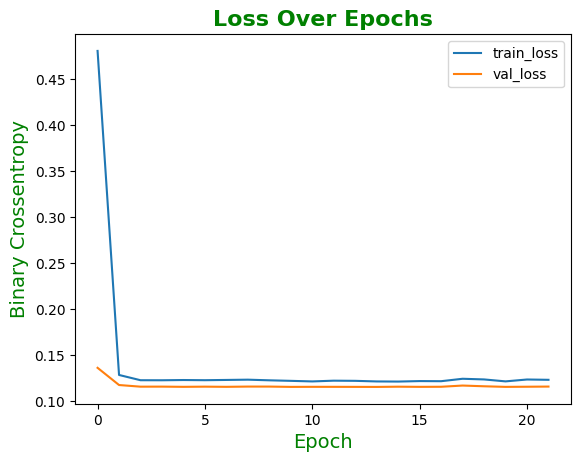

In [431]:
# Plotting Loss over Epochs
plt.plot(hist['loss'], label='train_loss')
plt.plot(hist['val_loss'], label='val_loss')
plt.title("Loss Over Epochs", fontsize=16, fontweight="bold", color="Green")
plt.xlabel("Epoch", fontsize=14, color="Green")
plt.ylabel("Binary Crossentropy", fontsize=14, color="Green")
plt.legend()

# Create the images directory if it doesn't exist
os.makedirs('images', exist_ok=True)

# Save the plot as an image
plt.savefig(f"images/loss_over_epoch.png", dpi=300, bbox_inches='tight')

plt.show()


### Loss Curve Analysis

- The loss decreases sharply in the first epoch, stabilizing quickly for both training and validation.
- The validation loss remains slightly lower than the training loss, suggesting good generalization.
- No signs of overfitting are observed—validation loss does not increase with more epochs.
- The use of early stopping was effective, allowing the model to retain the best performing weights.

The model converged quickly and exhibits strong learning behavior, confirming the robustness of the training process.


## 8. Test Set Evaluation

We evaluate the model's performance on the unseen **test set** using the same data generation strategy as in training.

- The test set generator replicates the preprocessing and formatting used in training.
- We report the final **binary crossentropy loss** and the **AUC score** on the test set.
- A high AUC indicates strong predictive performance on real unseen student interactions.

In [420]:
# We rebuild test-generator EXACTLY as in fit()
test_gen = DKTNextStepGenerator(test_df, batch_size=batch_size, max_len=max_len)

# We evaluate on the test set
test_loss, test_auc = model.evaluate(test_gen, verbose=1) # evaluate returns [loss, auc]

print(f"\nTest loss: {test_loss:.4f}")
print(f"Test AUC  : {test_auc:.4f}")


6/6 [==============================] - 19s 3s/step - loss: 0.1182 - auc: 0.9039

Test loss: 0.1182
Test AUC  : 0.9039


### Final Test Evaluation

- The model achieves a **test loss of 0.1182** and an **AUC of 0.9039** on unseen data.
- This performance is consistent with the validation results (val_auc ≈ 0.9012), indicating that the model generalizes well and is not overfitting.
- An AUC above 0.90 confirms that the model is able to distinguish between likely correct and incorrect responses with high confidence.

These results validate the model's effectiveness for knowledge tracing and its readiness for deployment or further analysis.

## 9. Analysis & Visualization

This section explores the behavior of the trained DKT model by visualizing its predictions at the student level and evaluating its calibration globally.

We divide the analysis into two key components:

1. **Learning Curves**: For a selected subset of high-performing students (based on test accuracy), we visualize the predicted probability of correctly answering the *next question* at each step, compared to the actual correctness. This helps understand how the model tracks individual learning dynamics over time.

2. **Calibration Curve**: We evaluate how well the predicted probabilities align with actual outcomes, globally. By grouping predictions into bins and comparing the average predicted probability to the actual hit rate in each bin, we assess whether the model is well-calibrated or systematically over-/under-confident.

These visualizations provide insight into the model's interpretability, trustworthiness, and suitability for real-world educational applications.

### **Learning curves**: visualize predicted probability vs. actual outcome for a few students

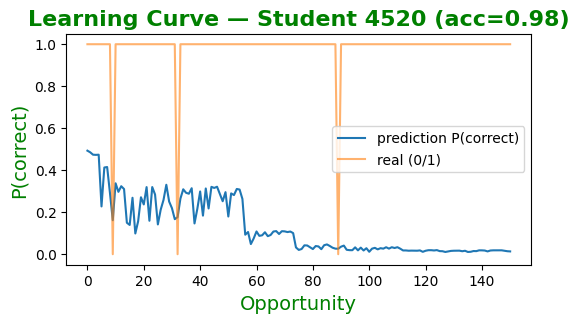

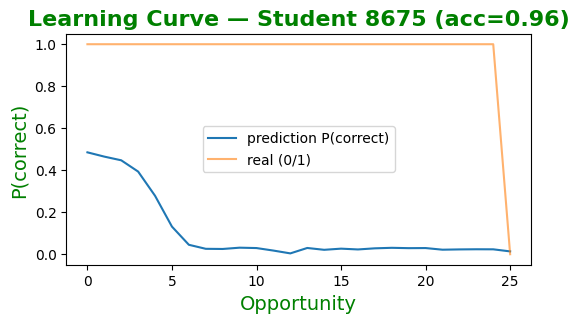

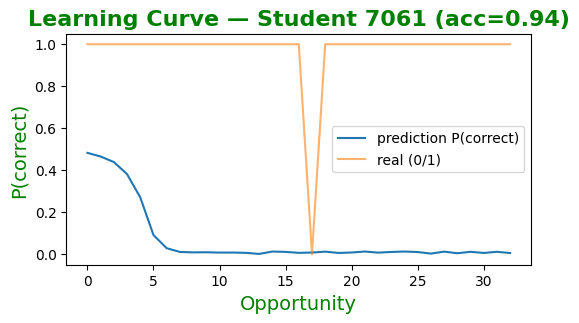

In [430]:
# Calculate the overall hit rate per student in test_df
user_accuracy = test_df.groupby('user_id')['correct'].mean()

# We chose the N students with the highest hit rate.
N = 3
top_users = user_accuracy.sort_values(ascending=False).head(N).index

def plot_learning_curve(model, df, qid2idx, max_len, user_id):
    seq = df[df['user_id']==user_id].sort_values('start_time')
    if len(seq) < 2:
        return
    T = min(len(seq)-1, max_len)
    X = np.zeros((1, max_len, 2*M), dtype=np.float32)
    preds, actual = [], []
    for t in range(T):
        q = qid2idx[seq.iloc[t].question_id]
        X[0, t, q + (0 if seq.iloc[t].correct else M)] = 1.0
        # predict the hit prob. at t+1 using only the prefix up to t
        p_all = model.predict(X[:, :t+1, :], verbose=0)[0]
        next_q = qid2idx[seq.iloc[t+1].question_id]
        preds.append(p_all[next_q])
        actual.append(int(seq.iloc[t+1].correct))
    
    plt.figure(figsize=(6,3))
    plt.plot(preds, label='prediction P(correct)')
    plt.plot(actual, label='real (0/1)', alpha=0.6)
    plt.ylim(-0.05,1.05)
    plt.title(f"Learning Curve — Student {user_id} (acc={user_accuracy[user_id]:.2f})", fontsize=16, fontweight="bold", color="Green")
    plt.xlabel("Opportunity", fontsize=14, color="Green")
    plt.ylabel("P(correct)", fontsize=14, color="Green")
    plt.legend()
    # Save the plot as an image
    plt.savefig(f"images/learning_curve_student_{user_id}", dpi=300, bbox_inches='tight')
    plt.show()

# We draw the top-N curves
for u in top_users:
    plot_learning_curve(model, test_df, qid2idx, max_len, u)


### Interpretation of Learning Curves

Despite selecting the students with the highest accuracy in the test set, the learning curves reveal a concerning pattern:

- The predicted probability of correctly answering the next question (*P(correct)*) shows a **sharp decline** over time.
- After a few steps, the model consistently predicts probabilities close to **zero**, even when the student continues to answer correctly.
- This indicates that the model **loses confidence** in the student's knowledge state as time progresses, regardless of actual performance.

#### Actions Taken to Solve the Issue

Several modifications were attempted in an effort to fix this undesired behavior:

1. **Switching to *return_sequences=True*** in the LSTM layer to produce predictions at every timestep, instead of only the final one.
2. **Modifying the loss function** to compute binary cross-entropy only over valid steps, using a masking mechanism that tracks which timesteps have valid targets.
3. **Redesigning the data generator (*DKTNextStepGenerator*)**, especially the *__getitem__* method, to:
   - Encode *Y* correctly at each step.
   - Include a custom masking array concatenated to *Y* for use during loss computation.
4. **Using "accuracy" instead of AUC** as the main training metric to better align with classification behavior.
5. **Testing an alternative input representation**, by replacing the *Masking* layer with an *Embedding* layer, to examine whether sparse inputs contributed to poor signal propagation.

Unfortunately, **none of these modifications resolved the issue**. The model continues to predict diminishing probabilities across time, failing to reflect actual student performance.

#### Possible Causes

- **Label sparsity**: Each training label only provides feedback on *one* output per timestep (the next question), while the output vector contains probabilities for *all* questions. This can result in **poor gradient flow** and difficulty in learning discriminative knowledge states.
- **Bias in loss aggregation**: Even with masking, the loss might not be effectively guiding the model to track student knowledge if most sequences are dominated by few valid prediction points.
- **Model capacity or structure**: A single LSTM layer with a dense output may be insufficient to model complex knowledge transitions.
- **Over-regularization or gradient vanishing**: Dropout, masking, or input sparsity may inhibit learning dynamics.

#### Implications

This behavior **limits the usability** of the model for key educational tasks:

- It would fail to provide **accurate personalized recommendations** (e.g., which skill the student is ready to tackle next).
- Its low confidence would result in **underestimating learner competence**, potentially harming motivation if used in real-time tutoring systems.

#### Suggested Next Steps

To address the issue more effectively, future directions may include:

- **Modifying the target formulation** to consider only the next step as output (*(batch, seq_len, 1)*), instead of a full one-hot over questions.
- **Training a separate readout layer** with attention or filtering mechanisms focused solely on the actual question at *t+1*, possibly using a contrastive or ranking loss.
- **Experimenting with knowledge-aware embeddings** or pretraining on skill-level transitions before full DKT fine-tuning.
- **Switching to loss functions or evaluation strategies** that directly penalize the predicted probability at *q_{t+1}* only, avoiding full softmax across all questions.
- **Debugging with synthetic data** (toy dataset with 10 questions and controlled behavior) to confirm whether the issue stems from data or model architecture.

> In summary, while the current implementation produces a strong AUC, the predicted trajectories suggest that the model is not learning to **track** knowledge over time—only to **score** sequences globally. This misalignment should be addressed before using the model for decision-making or personalized interventions.


### **Global calibration**: We plot the actual hit rate vs. the average predicted probability for each question

                  bin    p_mean    y_rate  count
0  (0.000104, 0.0556]  0.021340  0.565657    198
1      (0.0556, 0.11]  0.094844  0.800000    145
2       (0.11, 0.165]  0.154364  0.000000      4
3       (0.165, 0.22]  0.194370  0.400000     15
4       (0.22, 0.275]  0.247056  1.000000      4
5       (0.275, 0.33]  0.309506  0.591241    137
6       (0.33, 0.385]  0.336628  0.428571      7
7       (0.385, 0.44]  0.410223  0.882353     17
8       (0.44, 0.495]       NaN       NaN      0
9       (0.495, 0.55]  0.541023  1.000000      2


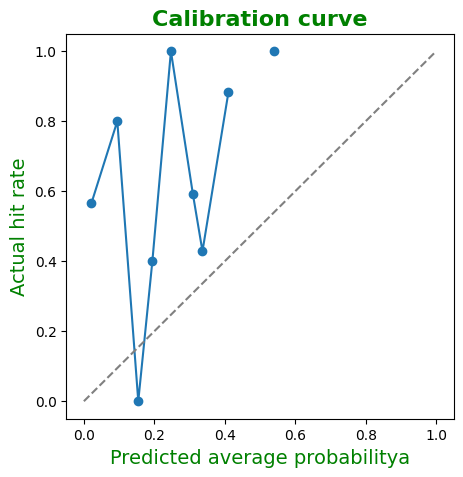

In [432]:
# Global calibration

probs, truths = [], []

for u in test_df['user_id'].unique():
    seq = test_df[test_df['user_id']==u].sort_values('start_time')
    if len(seq)<2: 
        continue
    # we build X to the last possible step
    last = min(len(seq)-2, max_len-1)
    X = np.zeros((1, max_len, 2*M), dtype=np.float32)
    for t, row in enumerate(seq.itertuples()):
        if t > last: break
        q = qid2idx[row.question_id]
        X[0,t, q + (0 if row.correct else M)] = 1.0
    # we predict NEXT-STEP at once (return_sequences=False)
    p_all = model.predict(X, verbose=0)[0]   # vector size M
    # royal label
    nxt = seq.iloc[last+1]
    probs.append(p_all[qid2idx[nxt.question_id]])
    truths.append(int(nxt.correct))

# we assemble the calibration DataFrame
cal_df = pd.DataFrame({'p_pred': probs, 'y_true': truths})
cal_df['bin'] = pd.cut(cal_df['p_pred'], bins=10)

calibration = cal_df.groupby('bin', observed=False).agg(
    p_mean=('p_pred','mean'),
    y_rate=('y_true','mean'),
    count=('y_true','size'),
).reset_index()

print(calibration)

# we plot the calibration curve
plt.figure(figsize=(5,5))
plt.plot(calibration['p_mean'], calibration['y_rate'], marker='o')
plt.plot([0,1],[0,1], '--', color='gray')
plt.xlabel("Predicted average probabilitya", fontsize=14, color="Green")
plt.ylabel("Actual hit rate", fontsize=14, color="Green")
plt.title("Calibration curve", fontsize=16, fontweight="bold", color="Green")
plt.show()

We evaluated the calibration of the DKT model by comparing the predicted probabilities (P(correct)) with the actual hit rates of the students, grouped in 10 bins. The calibration curve shows a clear trend:

- Most of the model predictions fall in the range [0.0, 0.6], indicating that the model tends to assign low probabilities, even to answers that were ultimately correct.

- All but one of the points fall above the reference diagonal, suggesting that the model is poorly calibrated but conservative:

    - It predicts lower values than it should.

    - In other words, it underestimates the probability that students will answer correctly.

- This is consistent with what has been observed in individual learning curves, where even high-performing students receive low and decreasing predictions over time.

This behavior indicates that, although the model may be capturing some signal (reasonable AUC), it is not calibrating its predictions well, which could be due to training biased by the way the loss over valid steps is calculated. That is, the model is not learning to correctly predict the probability of success as a function of the student's history, but is fitting an average behavior of students in the data set. This can be a problem if you want to use the model to make personalized recommendations or to assess individual student performance.

## 10. Conclusion

This project implemented and analyzed the **Deep Knowledge Tracing (DKT)** model to predict student performance based on historical question-response interactions. Using an LSTM-based architecture, we trained and evaluated the model on a large educational dataset containing student responses, with the aim of forecasting future correctness and understanding student learning dynamics.

### Key Findings

- The model achieved **strong overall performance**, with a final **validation AUC of 0.9012** and **test AUC of 0.9039**, indicating that the model captures some signal relevant to predicting student outcomes.

- The **loss curves** showed stable convergence, with both training and validation loss flattening after a few epochs, confirming that the model trained without overfitting.

- Despite the promising aggregate metrics, **learning curve visualizations** revealed that the predicted probabilities for correctly answering the next question **decrease steadily over time**, even for students with high actual performance.

- The **global calibration curve** showed a clear underestimation trend, with most predictions falling below actual performance levels. The model appears systematically conservative, assigning low probabilities even in cases where students consistently answer correctly.

### Limitations

- The model fails to **accurately track individual knowledge progression**, as evidenced by declining learning curves across time steps.

- Multiple attempts to mitigate the issue—including architectural changes (*return_sequences=True*), custom loss masking, switching metrics, and embedding layers—did not resolve the problem.

- The model’s output, a dense prediction over all questions at each timestep, may suffer from **label sparsity**, where supervision is only provided for a single target per step.

- The conservative predictions and poor calibration limit the model’s usability in **real-time adaptive learning systems**, **recommendation engines**, or **personalized interventions**.

### Next Steps


1. **Target-Specific Training**: Restructure the model to only predict the next-question outcome (e.g., via index-based readout or dot-product over embeddings), reducing the noise from predicting all possible outcomes.

2. **Alternative Loss Functions**: Explore contrastive or pairwise ranking losses that emphasize prediction of the correct next question rather than optimizing binary cross-entropy over all questions.

3. **Skill-Aware or Hierarchical Modeling**: Introduce *skill-level features* (e.g., general_cat) and hierarchical models that incorporate both question-level and skill-level dynamics.

4. **Temporal Attention Mechanisms**: Implement attention-based models like **Self-Attentive Knowledge Tracing (SAKT)** to better capture long-range dependencies and focus learning on relevant parts of the history.

5. **Calibration-Aware Training**: Integrate loss regularization or post-hoc calibration methods (e.g., temperature scaling) to align predicted probabilities with actual correctness likelihoods.

6. **Use of Synthetic or Smaller Datasets**: Create a controlled, small-scale dataset to isolate the effect of each model component and confirm whether the issue stems from architecture or data preprocessing.



By combining strong baseline results with detailed visual diagnostics, this study highlights both the potential and the current limitations of DKT. Improving the model’s ability to **track and represent evolving student knowledge** remains an essential goal for future iterations.
